# AutoGluon and probability calibration

# 確率補正に必要なsklearn APIの取り付け

本連載では分類モデルの予測値を信頼性曲線にプロットしたり、
クラス確率に近づける確率補正について取り上げています。
前回、sklearn APIが元々備わっていたLightGBMモデルを対象にしましたが、
今回は、[AutoGluon Tabular](https://pypi.org/project/autogluon.tabular/) という AutoML を対象に、
確率補正に必要なAPIメソッドを取り付ける
具体例をご紹介します。



## ライブラリの用意

sklearn を使って信頼性曲線を書いたり確率補正します。
図形は Matplotlib と Plotly で作ります。
補正対象のモデルとしては 
[AutoGluon Tabular](https://pypi.org/project/autogluon.tabular/)
を使います。
AutoGluon内部では 
[lightgbm](https://lightgbm.readthedocs.io/en/latest/),
[catboost](https://catboost.ai/),
[xgboost](https://xgboost.readthedocs.io/en/latest/)
などが使われます。

Condaやpipでそれぞれインストールできます。

## サンプルデータ

[Adult Census Income (国勢調査の成人収入)](https://archive.ics.uci.edu/ml/datasets/census+income)
を使います。5万ドル以上の年収があるかどうかを分類するデータセットです。
このデータは元々正例の割合が少なく、偏っていますが、
更にノイズを投入しました。

In [ ]:
import numpy as np
import shap
import sklearn
from sklearn.model_selection import train_test_split

## Census income
X, y = shap.datasets.adult()
X = X.values

print("Original dataframe shape", X.shape)
n_samples, n_features = X.shape

# Add noise
random_state = np.random.RandomState(0)
X = X + 4 * random_state.randn(n_samples, n_features)
X = np.c_[X, random_state.randn(n_samples, 100 * n_features)]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state
)
print("Noisy dataframe shape", X.shape)
print("Classes", np.unique(y))

X_test, X_calib, y_test, y_calib = train_test_split(
    X_test,
    y_test,
    test_size=4000 / len(X_test),
    random_state=random_state,
)
print("学習・補正・テスト用データ比率", np.array([len(X_train), len(X_calib), len(X_test)]) / len(X))

Original dataframe shape (32561, 12)
Noisy dataframe shape (32561, 1212)
Classes [False  True]
学習・補正・テスト用データ比率 [0.74997697 0.12284635 0.12717668]


In [ ]:
from autogluon.tabular import TabularDataset

tr_data = TabularDataset(X_train)
tr_data["y"] = y_train
tr_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1203,1204,1205,1206,1207,1208,1209,1210,1211,y
0,55.150679,0.190716,11.639823,0.984050,4.207856,-0.438618,4.075127,-0.177213,4.419674,2261.400319,...,-0.421482,-0.492354,2.188931,1.890532,1.197646,-0.915642,-0.745367,1.309365,-0.558290,False
1,44.324625,4.568088,14.691406,4.085347,-0.986166,5.562246,-0.689750,-8.195224,1.908657,-2.469216,...,-0.248147,0.188788,0.759042,1.183562,0.641865,0.095657,1.481117,-1.294230,-1.477307,True
2,49.161768,3.504227,10.344601,2.898027,18.864769,3.734059,5.944307,0.445238,3.814409,4.375051,...,-0.108891,-1.597474,-0.557484,0.274719,0.834568,-0.155843,0.292481,0.363087,0.687930,True
3,38.375623,10.634179,14.367692,11.401001,11.490676,-1.866726,-0.675371,8.023515,4.178944,-7.578039,...,1.123319,-0.363197,-0.915543,-0.721841,1.290744,-0.400617,-0.254988,-1.682269,-1.519599,False
4,51.941775,4.504722,8.233571,0.416077,0.989725,-2.964122,-0.766150,2.836963,1.554746,-7.509606,...,0.700531,0.465055,1.754451,-0.510019,-0.118499,0.867805,-0.419116,-0.296483,0.815914,False


In [ ]:
te_data = TabularDataset(X_test)
te_data["y"] = y_test
te_data.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,0,1,2,3,4,5,6,7,8,9,...,1203,1204,1205,1206,1207,1208,1209,1210,1211,y
0,62.255383,5.831143,12.638373,-4.375959,11.950415,2.638438,-2.181352,-1.075052,-1.040339,-4.046030,...,0.627686,-1.381202,0.235047,0.781438,0.352366,0.583754,1.224902,0.350085,0.407340,False
1,42.304418,1.507765,9.225236,7.568787,15.296958,4.998232,3.006109,0.383081,5.057561,3.583399,...,-1.687568,0.528663,-1.178646,1.333547,-0.557322,0.489001,0.372340,0.810345,-0.431861,False
2,25.362705,0.099063,4.370707,17.376790,9.849307,0.636375,7.183748,-0.959921,0.136696,4.054935,...,-0.892634,0.120163,0.872914,0.651086,0.625578,-1.243911,0.635322,1.444986,0.077606,False
3,10.007130,12.341750,4.399064,-1.052642,10.981154,-1.703968,3.493526,-0.566090,-1.110927,7.241747,...,-1.264475,-2.235201,0.915248,1.041231,0.544913,1.468259,-1.761762,3.205364,0.742915,False
4,25.622787,4.829471,7.509705,3.995892,5.798364,2.085136,0.069773,-0.438765,-4.660486,1.304545,...,0.425200,1.008140,0.618921,1.234493,-0.278199,0.851198,0.133332,-0.467102,1.612342,False


In [ ]:
tr_data.y.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


count     24420
unique        2
top       False
freq      18577
Name: y, dtype: object

In [ ]:
te_data.y.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


count      4141
unique        2
top       False
freq       3098
Name: y, dtype: object

## モデル学習

AutoGluonモデルを学習データにフィットさせます。

In [ ]:
from autogluon.tabular import TabularPredictor

save_path = "trained-model"
predictor = TabularPredictor(label="y", path=save_path).fit(
    tr_data, hyperparameters="toy", time_limit=30
)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Beginning AutoGluon training ... Time limit = 30s
AutoGluon will save models to "trained-model/"
AutoGluon Version:  0.1.0
Train Data Rows:    24420
Train Data Columns: 1212
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [False, True]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6431.88 MB
	Train Data (Original)  M

## Sklearnラッパー

sklearnを使って確率補正を行うために、必要なインタフェースを用意する。

試験データでメトリック AUC, Brier を図り、信頼性曲線を書いてみます。

In [ ]:
from fastcore.basics import store_attr


class AutoGluonWrapper:
    """
    sklearnを使って信頼性曲線を描いたり、確率補正を行うために、
    必要なインタフェースを用意する。
    """

    def __init__(
        self,
        trained_model_path,  # AutoGluon学習済みモデルの保存パス
        classes_,  # sklearn APIに求められる属性
    ):
        store_attr()

    def load_model(self):
        """ AutoGluon学習済みモデルをロード """
        self.ag_model = TabularPredictor.load(self.trained_model_path)

    def fit(self):
        """ sklearn API に求められるメソッド """
        return True

    def predict_proba(self, X):
        """ sklearn API に求められるメソッド """
        X = TabularDataset(X)
        proba = self.ag_model.predict_proba(X)
        return proba.values

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
ag_ = AutoGluonWrapper(save_path, classes_=np.unique(y))
ag_.load_model()

## 信頼性曲線

試験データに対してメトリック AUC, Brier を図り、信頼性曲線を書いてみます。
前回定義したメソッド `plot_calibration_curve` を使います。

In [ ]:
from kowaza.proba_calib import plot_calibration_curve

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


AutoGluon:
	AUC  : 0.818
	Brier: 0.162



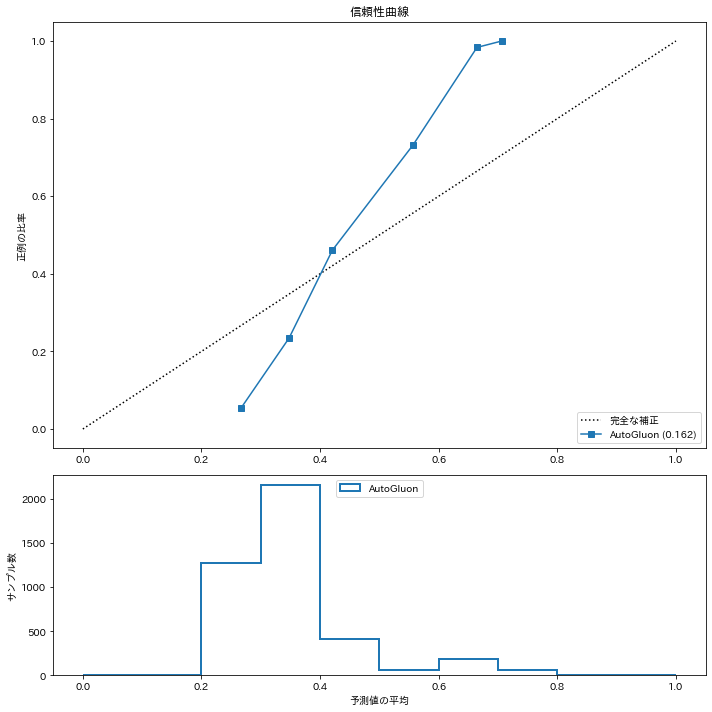

In [ ]:
plot_calibration_curve(dict(AutoGluon=ag_), X_test, y_test)

## 確率補正の実施

補正するために[sklearn.calibration. CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV)を使います。 `cv = "prefit"` と指定することによって、ベースモデルが学習済みであり、補正モデルに渡すデータは全量補正用であることを伝えます。

今回は確率補正方法として `sigmoid` と `isotonic` をそれぞれ使ってみましょう。

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

sigmoid = CalibratedClassifierCV(ag_, cv="prefit", method="sigmoid")
sigmoid.fit(X_calib, y_calib)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CalibratedClassifierCV(base_estimator=<__main__.AutoGluonWrapper object at 0x7fa40a7d3b50>,
                       cv='prefit')

In [ ]:
isotonic = CalibratedClassifierCV(ag_, cv="prefit", method="isotonic")
isotonic.fit(X_calib, y_calib)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CalibratedClassifierCV(base_estimator=<__main__.AutoGluonWrapper object at 0x7fa40a7d3b50>,
                       cv='prefit', method='isotonic')

補正前と補正後のモデルの信頼性曲線を同じ図に書いて比較してみましょう。

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


AutoGluon:
	AUC  : 0.818
	Brier: 0.162



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Sigmoid:
	AUC  : 0.818
	Brier: 0.134



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Isotonic:
	AUC  : 0.818
	Brier: 0.133



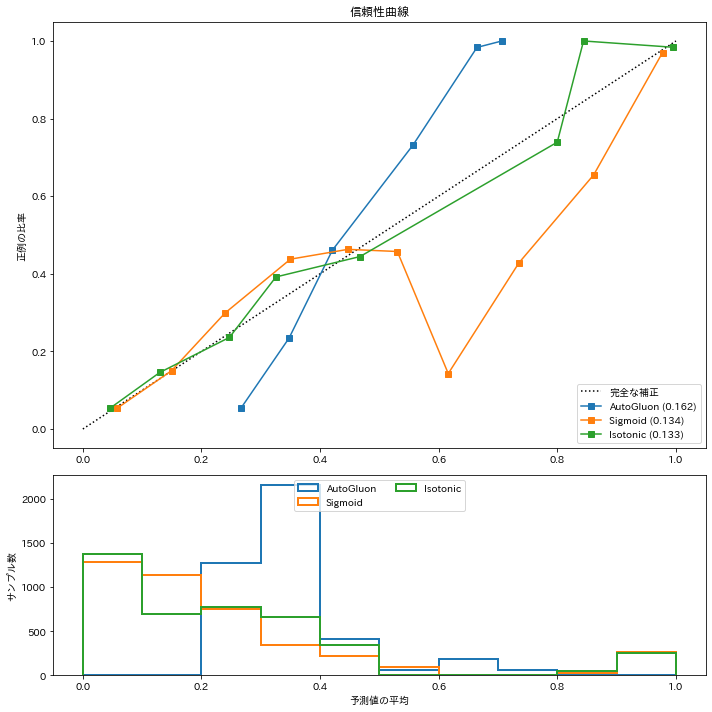

In [ ]:
plot_calibration_curve(
    dict(
        AutoGluon=ag_,
        Sigmoid=sigmoid,
        Isotonic=isotonic,
    ),
    X_test,
    y_test,
)

補正の結果、信頼性曲線が改善され、Brierスコアも改善されました。
最も、対象データセットにノイズを投入せずにAutoGluonに学習させると、確率補正を行わなくてもきれいな信頼性曲線が得られます。
しかし、実運用では、データに必ずノイズが含まれるし、データの分布も時間とともに少しずつ変化していくものなので、信頼性曲線をプロットして必要に応じて確率補正を行う必要があります。


## まとめ

第１回目に、分類モデルの出力値が必ずしもクラス確率とは限らないので、信頼性曲線を確認したり、確率補正を行ってみました。
今回は、sklearnが規定しているインタフェースを持たない学習済みモデルの補正実験を行いました。
次回は、確率補正に関する背景的な理論について書ければと思います。
